In [1]:
using DifferentialEquations, DiffEqParamEstim, RecursiveArrayTools, Optim, LineSearches, BlackBoxOptim, LinearAlgebra, 
Random, DiffEqSensitivity, CSV, Tables, Plots

gr() #choosing GR backend for plots

Plots.GRBackend()

In [2]:
#Modelling the Network 

In [3]:
function define_py!(du, u, t) #mutating function- alters contents of params
    
    #defining constants
    c_m = 1*(10^-3)
    g_na = 50
    E_na = 100
    g_k = 80
    E_k = -100
    i_app = 1.8 # applied current
    
    # sodium current i_na
    alpha_m_na = (0.32*(u[1]+54)) / (1 - exp(-(u[1]+54)/4)) #opening rate sodium activation gate
    beta_m_na = (0.28*(u[1]+27)) / (exp((u[1]+27)/5) -1) #closing rate sodium activation gate

    alpha_h_na = 0.128*exp(-(u[1]+50)/18) #opening rate sodium inactivation gate
    beta_h_na = 4 / (1 + exp(-(u[1]+27)/5)) #closing rate sodium inactivation gate

    i_na = g_na*(u[2]^3)*u[3]*(u[1]-E_na)

    # potassium current i_k
    alpha_m_k = (0.032*(u[1]+52)) / (1 - exp(-(u[1]+52)/5)) #opening rate potassium activation gate
    beta_m_k = 0.5*exp(-(u[1]+57)/40) #closing rate potassium activation gate
    
    i_k = g_k*(u[4]^4)*(u[1]-E_k) # potassium current

    # leakage current i_l
    i_l = 0.1*(u[1]+61)

    # membrane current i_memb
    i_memb = i_na + i_k + i_l

    #total current i
    i = i_app - i_memb

    # dynamic equations
    du[1] = i/c_m # membrane voltage: dV
    du[2] = alpha_m_na*(1-u[2]) - beta_m_na*u[2] # activation gate: dm_na
    du[3] = alpha_h_na*(1-u[3]) - beta_h_na*u[3] # inactivation gate: dh_na
    du[4] = alpha_m_k*(1-u[4]) - beta_m_k*u[4] # activation gate: dm_k
    
    return du
end

define_py! (generic function with 1 method)

In [4]:
function define_lts!(du, u, t) #mutating function- alters contents of params
    
    #defining constants
    c_m = 1*(10^-3)
    g_na = 50
    E_na = 100
    g_k = 80
    E_k = -100
    g_M = 2
    E_M = -100
    i_app = 1 #mean applied current
    
    # sodium current i_na
    alpha_m_na = (0.32*(u[1]+54)) / (1 - exp(-(u[1]+54)/4)) #opening rate sodium activation gate
    beta_m_na = (0.28*(u[1]+27)) / (exp((u[1]+27)/5) -1) #closing rate sodium activation gate

    alpha_h_na = 0.128*exp(-(u[1]+50)/18) #opening rate sodium inactivation gate
    beta_h_na = 4 / (1 + exp(-(u[1]+27)/5)) #closing rate sodium inactivation gate

    i_na = g_na*(u[2]^3)*u[3]*(u[1]-E_na)

    # potassium current i_k
    alpha_m_k = (0.032*(u[1]+52)) / (1 - exp(-(u[1]+52)/5)) #opening rate potassium activation gate
    beta_m_k = 0.5*exp(-(u[1]+57)/40) #closing rate potassium activation gate

    i_k = g_k*(u[4]^4)*(u[1]-E_k) # potassium current

    # leakage current i_l
    i_l = 0.1*(u[1]+61)

    # M current i_M
    alpha_m_M = (3.209*(10^-4)*(u[1]+30)) / (1 - exp(-(u[1]+30)/9 )) #opening rate M activation gate
    beta_m_M = -(3.209*(10^-4)*(u[1]+30)) / (1 - exp((u[1]+30)/9))   #closing rate M activation gate

    i_M = g_M*u[5]*(u[1]-E_M)

    # membrane current i_memb
    i_memb = i_na + i_k + i_l + i_M

    #total current i
    i = i_app - i_memb

    # dynamic equations
    du[1] = i/c_m # membrane voltage: dV
    du[2] = alpha_m_na*(1-u[2]) - beta_m_na*u[2] # activation gate: dm_na
    du[3] = alpha_h_na*(1-u[3]) - beta_h_na*u[3] # inactivation gate: dh_na
    du[4] = alpha_m_k*(1-u[4]) - beta_m_k*u[4] # activation gate: dm_k
    du[5] = alpha_m_M*(1-u[5]) - beta_m_M*u[5] # activation gate: dm_M

    return du
end

define_lts! (generic function with 1 method)

In [5]:
function define_re!(du, u, t) #mutating function- alters contents of params
    
    #defining constants
    c_m = 1*(10^-3) #uF/(cm^2)
    g_na = 200
    E_na = 50
    g_k = 20
    E_k = -100
    g_ca = 3
    E_ca = 120
    
    # sodium current i_na
    V_t_na = u[1] + 55

    alpha_m_na = (0.32*(13 -V_t_na)) / (exp((13-V_t_na)/4) - 1) #opening rate sodium activation gate
    beta_m_na = (0.28*(V_t_na-40)) / (exp((V_t_na-40)/5) -1) #closing rate sodium activation gate

    alpha_h_na = 0.128*exp((17-V_t_na)/18) #opening rate sodium inactivation gate
    beta_h_na = 4 / (1 + exp((40-V_t_na)/5)) #closing rate sodium inactivation gate

    i_na = g_na*(u[2]^3)*u[3]*(u[1]-E_na)

    # potassium current i_k
    V_t_k = u[1] + 55

    alpha_m_k = (0.032*(15-V_t_k)) / (exp((15-V_t_k)/5) -1) #opening rate potassium activation gate
    beta_m_k = (0.5*(10-V_t_k)) / exp((10-V_t_k)/40) #closing rate potassium activation gate

    i_k = g_k*(u[4]^4)*(u[1]-E_k) # potassium current

    # T current i_T
    V_t_T = u[1] + 2

    m_infin = 1 / (1 + exp(-(V_t_T+52)/7.4))
    h_infin = 1 / (1 + exp((V_t_T+80)/5))
    tau_h = 22.7 + (0.27/(exp((V_t_T+48)/4) + exp(-(V_t_T+407)/50)))
    tau_m = 0.44 + (0.15/(exp((V_t_T+27)/10) + exp(-(V_t_T+102)/15)))
    
    i_T = g_ca*(u[6]^2)*u[5]*(u[1]-E_ca)
    
    i_l = 0.05*(u[1]+90) #leakage current i_l

    # membrane current i_memb
    i_memb = i_na + i_k + i_l + i_T

    #total current i
    i = - i_memb

    # dynamic equations
    du[1] = i/c_m # membrane voltage: dV
    du[2] = alpha_m_na*(1-u[2]) - beta_m_na*u[2] # activation gate: dm_na
    du[3] = alpha_h_na*(1-u[3]) - beta_h_na*u[3] # inactivation gate: dh_na
    du[4] = alpha_m_k*(1-u[4]) - beta_m_k*u[4] # activation gate: dm_k
    du[5] = (h_infin - u[5]) / tau_h # inactivation gate: dh_T
    du[6] = (m_infin - u[6]) / tau_m # inactivation gate: dm_T
    
    return du
end

define_re! (generic function with 1 method)

In [6]:
function define_tc!(du, u, t) #mutating function- alters contents of params
    
    #defining constants
    c_m = 1*(10^-3) #uF/(cm^2)
    g_na = 90
    E_na = 50
    g_k = 10
    E_k = -100
    g_ca = 2
    E_ca = 120
    g_H = 0.25
    E_H = -40
    
    # sodium current i_na
    V_t_na = u[1] + 35

    alpha_m_na = (0.32*(13 -V_t_na)) / (exp((13-V_t_na)/4) - 1) #opening rate sodium activation gate
    beta_m_na = (0.28*(V_t_na-40)) / (exp((V_t_na-40)/5) -1) #closing rate sodium activation gate

    alpha_h_na = 0.128*exp((17-V_t_na)/18) #opening rate sodium inactivation gate
    beta_h_na = 4 / (1 + exp((40-V_t_na)/5)) #closing rate sodium inactivation gate

    i_na = g_na*(u[2]^3)*u[3]*(u[1]-E_na)


    # potassium current i_k
    V_t_k = u[1] + 25

    alpha_m_k = (0.032*(15-V_t_k)) / (exp((15-V_t_k)/5) -1) #opening rate potassium activation gate
    beta_m_k = (0.5*(10-V_t_k)) / exp((10-V_t_k)/40) #closing rate potassium activation gate

    i_k = g_k*(u[4]^4)*(u[1]-E_k) # potassium current

    # T current i_T
    V_t_T = u[1] + 2

    m_infin = 1 / (1 + exp(-(V_t_T+57)/6.2))
    h_infin = 1 / (1 + exp((V_t_T+81)/4))
    tau_h = (30.8 + (211.4 + exp((V_t_T+113.2)/5) / (1 + exp((V_t_T+84)/3.2)))) / 3.73

    i_T = g_ca*(m_infin^2)*u[5]*(u[1]-E_ca)

    # H current i_H
    H_infin = 1 / (1+ exp((u[1]+75)/5.5))
    tau_s = 20 +  ( 1000 / ( (1+ exp((u[1]+71.5)/14.2)) + (1+ exp(-(u[1]+89)/11.6)) ) )

    alpha_H = H_infin / tau_s
    beta_H = (1-H_infin) / tau_s

    i_H = g_H*(u[6] + 2*(1-u[8]-u[6]))*(u[1]-E_H)

    # leakage current i_l
    i_l = 0.01*(u[1]+70) + 0.0172*(u[1]+100)

    # membrane current i_memb
    i_memb = i_na + i_k + i_l + i_T + i_H

    #total current i
    i = - i_memb

    # dynamic equations
    du[1] = i/c_m # membrane voltage: dV
    du[2] = alpha_m_na*(1-u[2]) - beta_m_na*u[2] # activation gate: dm_na
    du[3] = alpha_h_na*(1-u[3]) - beta_h_na*u[3] # inactivation gate: dh_na
    du[4] = alpha_m_k*(1-u[4]) - beta_m_k*u[4] # activation gate: dm_k
    du[5] = (h_infin - u[5]) / tau_h # inactivation gate: dh_T
    du[6] = 0.001*(1-u[8]-u[6]) - 0.001*((1-u[7])/0.01) # o_1
    du[7] = 0.0004*(1-u[7]) - 0.0004*((u[9]/0.002)^4) # p_0
    du[8] = beta_H*u[6] - alpha_H*u[8] # c_1
    du[9] = ((-10*i_T) / (2*96489)) + ((0.00024-u[9])/5) # [ca]i
    
    return du
end

define_tc! (generic function with 1 method)

In [7]:
function network!(du, u, p, t)
    
    #defining constants
    c_m = 1*(10^-3) #uF/(cm^2)
    E_GABA = -80
    E_AMPA = 0
    g_AMPA_P = 0.1
    g_AMPA_T = 0.1
    g_AMPA_R = 0.1
    
    tau, g_GABA_L, g_GABA_R = p #unpacking parameters
    
    #SYNAPTIC CURRENTS
    i_gaba_LP1 = g_GABA_L*u[49]*(u[1]-E_GABA) #LTS1-PY1
    i_ampa_PL1 = g_AMPA_P*u[50]*(u[6]-E_AMPA) #PY1-LTS1
    i_ampa_PR1 = g_AMPA_P*u[51]*(u[6]-E_AMPA) #PY1-RE1
    i_ampa_PT1 = g_AMPA_P*u[52]*(u[6]-E_AMPA) #PY1-TC1
    i_ampa_TP1 = g_AMPA_T*u[53]*(u[16]-E_AMPA) #TC1-PY1
    i_ampa_TR1 = g_AMPA_T*u[54]*(u[16]-E_AMPA) #TC1-RE1
    i_gaba_RT1 = g_GABA_R*u[55]*(u[10]-E_GABA) #RE1-TC1
    i_ampa_R1R2 = g_AMPA_R*u[56]*(u[10]-E_AMPA) #RE1-RE2
    i_gaba_R2R1 = g_GABA_R*u[57]*(u[34]-E_GABA) #RE2-RE1
    i_gaba_RT2 = g_GABA_R*u[58]*(u[34]-E_GABA) #RE2-TC2
    i_ampa_TR2 = g_AMPA_T*u[59]*(u[40]-E_AMPA) #TC2-RE2
    i_ampa_PR2 = g_AMPA_P*u[60]*(u[30]-E_AMPA) #PY2-RE2
    i_ampa_PT2 = g_AMPA_P*u[61]*(u[30]-E_AMPA) #PY2-TC2
    i_ampa_TP2 = g_AMPA_T*u[62]*(u[40]-E_AMPA) #TC2-PY2
    i_ampa_PL2 = g_AMPA_P*u[63]*(u[30]-E_AMPA) #PY2-LTS2
    i_gaba_LP2 = g_GABA_L*u[64]*(u[25]-E_GABA) #LTS2-PY2
    
    #NEURONS
    du[1], du[2], du[3], du[4], du[5] = define_lts!(du[1:5], u[1:5], t) #LTS1    
    du[6], du[7], du[8], du[9] = define_py!(du[6:9], u[6:9], t) #PY1
    du[10], du[11], du[12], du[13], du[14], du[15] = define_re!(du[10:15], u[10:15], t) #RE1
    du[16], du[17], du[18], du[19], du[20], du[21], du[22], du[23], du[24] = define_tc!(du[16:24], u[16:24], t) #TC1
    
    du[25], du[26], du[27], du[28], du[29] = define_lts!(du[25:29], u[25:29], t) #LTS2    
    du[30], du[31], du[32], du[33] = define_py!(du[30:33], u[30:33], t) #PY2
    du[34], du[35], du[36], du[37], du[38], du[39] = define_re!(du[34:39], u[34:39], t) #RE2
    du[40], du[41], du[42], du[43], du[44], du[45], du[46], du[47], du[48] = define_tc!(du[40:48], u[40:48], t) #TC2
     
    #UPDATED VOLTAGES
    du[1] = du[1] - i_ampa_PL1/c_m #PY1-LTS1
    du[6] = du[6] - i_gaba_LP1/c_m - i_ampa_TP1/c_m #LTS1-PY1 #TC1-PY1 
    du[10] = du[10] - i_ampa_PR1/c_m - i_ampa_TR1/c_m - i_gaba_R2R1/c_m #PY1-RE1 #TC1-RE1 #RE2-RE1
    du[16] = du[16] - i_ampa_PT1/c_m - i_gaba_RT1/c_m #PY1-TC1 #RE1-TC1
    du[25] = du[25] - i_ampa_PL2/c_m #PY2-LTS2
    du[30] = du[30] - i_ampa_TP2/c_m - i_gaba_LP2/c_m #TC2-PY2 #LTS2-PY2
    du[34] = du[34] - i_ampa_R1R2/c_m - i_ampa_TR2/c_m - i_ampa_PR2/c_m #RE1-RE2 #TC2-RE2 #PY2-RE2
    du[40] = du[40] - i_gaba_RT2/c_m - i_ampa_PT2/c_m #RE2-TC2 #PY2-TC2
    
    #SYNAPTIC ACTIVATION GATES
    du[49] = 2*(1+tanh(u[1]/4))*(1-u[49]) - u[49]/tau #LTS1-PY1 GABA
    du[50] = 5*(1+tanh(u[6]/4))*(1-u[50]) - u[50]/2 #PY1-LTS1 AMPA
    du[51] = 5*(1+tanh(u[6]/4))*(1-u[51]) - u[51]/2 #PY1-RE1 AMPA
    du[52] = 5*(1+tanh(u[6]/4))*(1-u[52]) - u[52]/2 #PY1-TC1 AMPA
    du[53] = 5*(1+tanh(u[16]/4))*(1-u[53]) - u[53]/2 #TC1-PY1 AMPA
    du[54] = 5*(1+tanh(u[16]/4))*(1-u[54]) - u[54]/2 #TC1-RE1 AMPA
    du[55] = 2*(1+tanh(u[10]/4))*(1-u[55]) - u[55]/tau #RE1-TC1 GABA
    
    du[56] = 5*(1+tanh(u[10]/4))*(1-u[56]) - u[56]/2 #RE1-RE2 AMPA
    du[57] = 2*(1+tanh(u[34]/4))*(1-u[57]) - u[57]/tau #RE2-RE1 GABA
    
    du[58] = 2*(1+tanh(u[34]/4))*(1-u[58]) - u[58]/tau #RE2-TC2 GABA
    du[59] = 5*(1+tanh(u[40]/4))*(1-u[59]) - u[59]/2 #TC2-RE2 AMPA
    du[60] = 5*(1+tanh(u[30]/4))*(1-u[60]) - u[60]/2 #PY2-RE2 AMPA
    du[61] = 5*(1+tanh(u[30]/4))*(1-u[61]) - u[61]/2 #PY2-TC2 AMPA
    du[62] = 5*(1+tanh(u[40]/4))*(1-u[62]) - u[62]/2 #TC2-PY2 AMPA
    du[63] = 5*(1+tanh(u[30]/4))*(1-u[63]) - u[63]/2 #PY2-LTS2 AMPA
    du[64] = 2*(1+tanh(u[25]/4))*(1-u[64]) - u[64]/tau #LTS2-PY2 GABA 

end

network! (generic function with 1 method)

In [8]:
#The influence of Propofol

In [9]:
#parameter values- baseline decay time and GABA conductances
tau_base = 5;
g_GABA_L_base = 0.15;
g_GABA_R_base = 0.06;

tau = tau_base;
g_GABA_L = g_GABA_L_base;
g_GABA_R = g_GABA_R_base;

In [10]:
#Generating training and test data

In [11]:
#Defining underlying function of training and test data

u0 = [0.0 for n in 1:64]
tspan = (0.0, 5.0)
p = [tau, g_GABA_L, g_GABA_R]
prob_ref = ODEProblem(network!,u0,tspan,p);

In [12]:
#Solving underlying function of training and test data
sol_ref = solve(prob_ref, AutoTsit5(Rosenbrock23(autodiff=false)), alghints=:auto, adaptive=false, dt=2*10^-4, 
    saveat=0.01);
#AutoTsit5(Rosenbrock23(autodiff=false))= good solver choice for unknown stiffness problems, uses default tolerances
#autodiff=false.. uses finite differentiation
#auto= allow the default handling algorithm to choose stiffness detection algorithms.
#adaptive= Turns on adaptive timestepping for appropriate methods
#saveat= defines the dt for the values to be saved- needed to circumvent mem allocation error when using 2 stage method

In [13]:
#adding noise to training and test data
t = collect(range(0,stop=5,length=128*5))
Random.seed!(1032); #ensuring the same data sets are generated each time
train_data = VectorOfArray([(sol_ref(t[i]) + randn(64)) for i in 1:length(t)])
Random.seed!(532); #ensuring the same data sets are generated each time
test_data = VectorOfArray([(sol_ref(t[i]) + randn(64)) for i in 1:length(t)])
#sol_ref(t[200]) returns solution array at time t[i]
#randn(64) Fills the array with normally-distributed (mean 0, standard deviation 1) random numbers.
train_data = convert(Array,train_data); #data matrix 64xlength(t)
test_data = convert(Array,test_data);

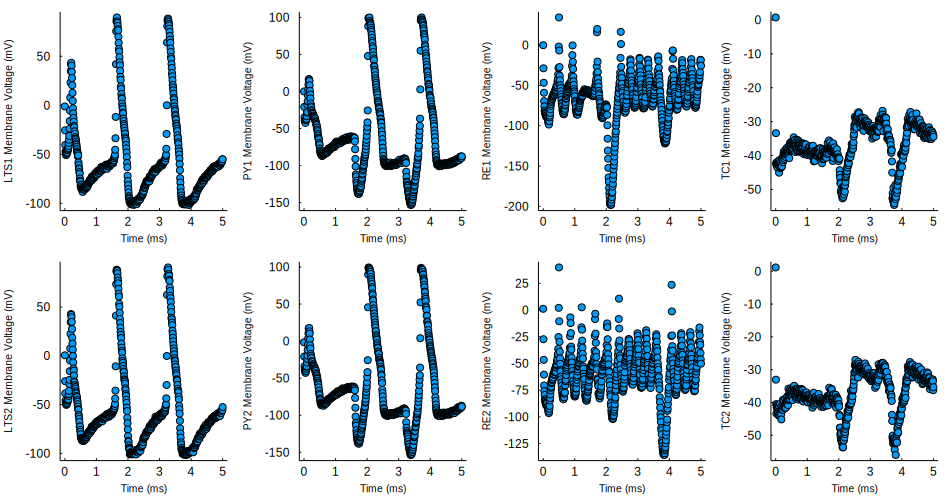

In [14]:
#plotting the training data- generated by solutions of ode with additive noise 
p1 = scatter(t, train_data[1,:], xlabel="Time (ms)", ylabel="LTS1 Membrane Voltage (mV)", guidefont=font(7))
p2 = scatter(t, train_data[6,:], xlabel="Time (ms)", ylabel="PY1 Membrane Voltage (mV)", guidefont=font(7)) 
p3 = scatter(t, train_data[10,:], xlabel="Time (ms)", ylabel="RE1 Membrane Voltage (mV)", guidefont=font(7))
p4 = scatter(t, train_data[16,:], xlabel="Time (ms)", ylabel="TC1 Membrane Voltage (mV)", guidefont=font(7))
p5 = scatter(t, train_data[25,:], xlabel="Time (ms)", ylabel="LTS2 Membrane Voltage (mV)", guidefont=font(7))
p6 = scatter(t, train_data[30,:], xlabel="Time (ms)", ylabel="PY2 Membrane Voltage (mV)", guidefont=font(7))
p7 = scatter(t, train_data[34,:], xlabel="Time (ms)", ylabel="RE2 Membrane Voltage (mV)", guidefont=font(7))
p8 = scatter(t, train_data[40,:], xlabel="Time (ms)", ylabel="TC2 Membrane Voltage (mV)", guidefont=font(7))

plot(p1, p2, p3, p4, p5, p6, p7, p8, layout=(2,4), size=(950, 500), legend=false, grid=false)
#savefig("SFAO_ECR.png")

In [15]:
#Parameter Estimation

In [16]:
# forming cost function
cost_function = build_loss_objective(prob_ref, AutoTsit5(Rosenbrock23(autodiff=false)), L2Loss(t,train_data),
    maxiters=10^4, verbose=false);
#L2Loss is an optimized version of the L2-distance. 
#maxiters= Maximum number of iterations before stopping
#verbose= Toggles whether warnings are thrown when the solver exits early. Defaults to true

In [17]:
# preparing for local optimization
lower = [0.01, 0.01, 0.01]
upper = [20.00, 0.60, 0.60]
initial_u = [15, 0.4, 0.4]
inner_optimizer = LBFGS(linesearch = LineSearches.BackTracking()); 
#LBFGS usually has a performance very close to that of BFGS, and avoids linear system solves (the parameter m can be 
#tweaked: increasing it can improve the convergence, at the expense of memory and time spent in linear algebra operations).
#BackTracking = rough linesearch- use for well-conditioned objective functions or faster performance needed
#HagerZhang = more stringent linesearch- use for badly behaved objective functions or extreme accuracy needed

In [18]:
result = optimize(cost_function, lower, upper, initial_u, Fminbox(inner_optimizer))

 * Status: success

 * Candidate solution
    Minimizer: [1.32e+01, 1.34e-01, 6.58e-02]
    Minimum:   7.166212e+04

 * Found with
    Algorithm:     Fminbox with L-BFGS
    Initial Point: [1.50e+01, 4.00e-01, 4.00e-01]

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.77e+07 ≰ 1.0e-08

 * Work counters
    Seconds run:   3959  (vs limit Inf)
    Iterations:    7
    f(x) calls:    4084
    ∇f(x) calls:   218


In [22]:
#plugging estimated parameter values into network to visualise output
prob_learnt = ODEProblem(network!, u0, tspan, [9.40e+00, 4.81e-01, 1.66e-01]); #result.minimizer);

In [23]:
sol_learnt = solve(prob_learnt, AutoTsit5(Rosenbrock23(autodiff=false)), alghints=:auto, adaptive=false, dt=10^-4, 
    saveat=0.01);

InterruptException: InterruptException:

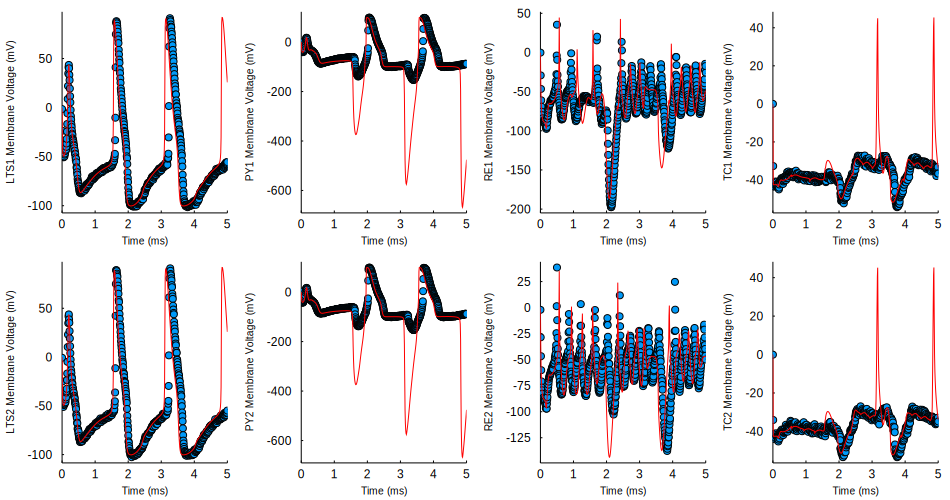

In [26]:
#plotting learnt model against test data

p1 = scatter(t, test_data[1,:])
p2 = scatter(t, test_data[6,:]) 
p3 = scatter(t, test_data[10,:])
p4 = scatter(t, test_data[16,:])
p5 = scatter(t, test_data[25,:])
p6 = scatter(t, test_data[30,:])
p7 = scatter(t, test_data[34,:])
p8 = scatter(t, test_data[40,:])

p1 = plot!(p1, sol_learnt, vars=(0,1), xlabel="Time (ms)", ylabel="LTS1 Membrane Voltage (mV)", guidefont=font(7),
    linecolor="red")
p2 = plot!(p2, sol_learnt, vars=(0,6), xlabel="Time (ms)", ylabel="PY1 Membrane Voltage (mV)", guidefont=font(7),
    linecolor="red")
p3 = plot!(p3, sol_learnt, vars=(0,10), xlabel="Time (ms)", ylabel="RE1 Membrane Voltage (mV)", guidefont=font(7),
    linecolor="red")
p4 = plot!(p4, sol_learnt, vars=(0,16), xlabel="Time (ms)", ylabel="TC1 Membrane Voltage (mV)", guidefont=font(7),
    linecolor="red")
p5 = plot!(p5, sol_learnt, vars=(0,25), xlabel="Time (ms)", ylabel="LTS2 Membrane Voltage (mV)", guidefont=font(7),
    linecolor="red")
p6 = plot!(p6, sol_learnt, vars=(0,30), xlabel="Time (ms)", ylabel="PY2 Membrane Voltage (mV)", guidefont=font(7),
    linecolor="red")
p7 = plot!(p7, sol_learnt, vars=(0,34), xlabel="Time (ms)", ylabel="RE2 Membrane Voltage (mV)", guidefont=font(7),
    linecolor="red")
p8 = plot!(p8, sol_learnt, vars=(0,40), xlabel="Time (ms)", ylabel="TC2 Membrane Voltage (mV)", guidefont=font(7),
    linecolor="red")

plot(p1, p2, p3, p4, p5, p6, p7, p8, layout=(2,4), size=(950, 500), legend=false, grid=false)
#savefig("SFAO_min6_sense.png")

In [27]:
#calculating L2 norm between test data and model
model = VectorOfArray([sol_learnt(t[i]) for i in 1:length(t)]) 
model = convert(Array,model) 
L2 = norm(model-test_data,2);
#metric for identifying how well model generalises to unseen data generated by the same underlying function

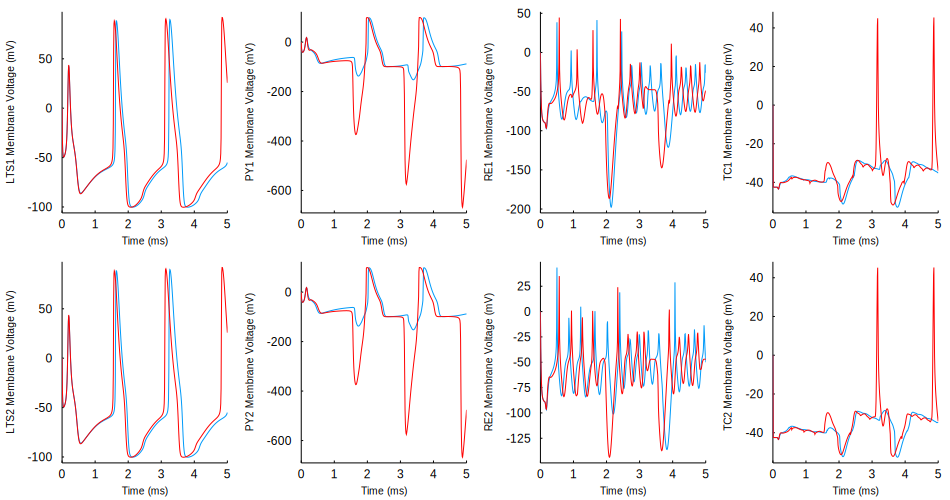

In [28]:
#plotting test solution against underlying function
p1 = plot(sol_ref, vars=(0,1), xlabel="Time (ms)", ylabel="LTS1 Membrane Voltage (mV)", guidefont=font(7))
p2 = plot(sol_ref, vars=(0,6), xlabel="Time (ms)", ylabel="PY1 Membrane Voltage (mV)", guidefont=font(7))
p3 = plot(sol_ref, vars=(0,10), xlabel="Time (ms)", ylabel="RE1 Membrane Voltage (mV)", guidefont=font(7))
p4 = plot(sol_ref, vars=(0,16), xlabel="Time (ms)", ylabel="TC1 Membrane Voltage (mV)", guidefont=font(7))
p5 = plot(sol_ref, vars=(0,25), xlabel="Time (ms)", ylabel="LTS2 Membrane Voltage (mV)", guidefont=font(7))
p6 = plot(sol_ref, vars=(0,30), xlabel="Time (ms)", ylabel="PY2 Membrane Voltage (mV)", guidefont=font(7))
p7 = plot(sol_ref, vars=(0,34), xlabel="Time (ms)", ylabel="RE2 Membrane Voltage (mV)", guidefont=font(7))
p8 = plot(sol_ref, vars=(0,40), xlabel="Time (ms)", ylabel="TC2 Membrane Voltage (mV)", guidefont=font(7))

p1 = plot!(p1, sol_learnt, vars=(0,1), xlabel="Time (ms)", ylabel="LTS1 Membrane Voltage (mV)", guidefont=font(7),
    linecolor="red")
p2 = plot!(p2, sol_learnt, vars=(0,6), xlabel="Time (ms)", ylabel="PY1 Membrane Voltage (mV)", guidefont=font(7),
    linecolor="red")
p3 = plot!(p3, sol_learnt, vars=(0,10), xlabel="Time (ms)", ylabel="RE1 Membrane Voltage (mV)", guidefont=font(7),
    linecolor="red")
p4 = plot!(p4, sol_learnt, vars=(0,16), xlabel="Time (ms)", ylabel="TC1 Membrane Voltage (mV)", guidefont=font(7),
    linecolor="red")
p5 = plot!(p5, sol_learnt, vars=(0,25), xlabel="Time (ms)", ylabel="LTS2 Membrane Voltage (mV)", guidefont=font(7),
    linecolor="red")
p6 = plot!(p6, sol_learnt, vars=(0,30), xlabel="Time (ms)", ylabel="PY2 Membrane Voltage (mV)", guidefont=font(7),
    linecolor="red")
p7 = plot!(p7, sol_learnt, vars=(0,34), xlabel="Time (ms)", ylabel="RE2 Membrane Voltage (mV)", guidefont=font(7),
    linecolor="red")
p8 = plot!(p8, sol_learnt, vars=(0,40), xlabel="Time (ms)", ylabel="TC2 Membrane Voltage (mV)", guidefont=font(7),
    linecolor="red")

plot(p1, p2, p3, p4, p5, p6, p7, p8, layout=(2,4), size=(950, 500), legend=false, grid=false)
#savefig("SFAO_min6_sense.png")

In [29]:
#EEG signals from training and test data

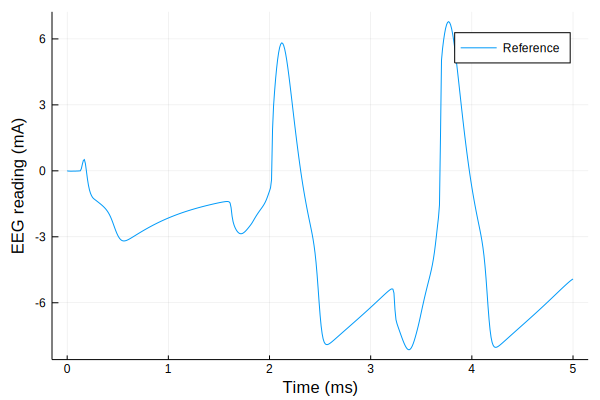

In [30]:
E_AMPA = 0
g_AMPA_P = 0.1

i_ampa_PL1_R = (g_AMPA_P*sol_ref[50,:]).*(sol_ref[6,:]-E_AMPA*ones((length(sol_ref[6,:]),1))) #PY1-LTS1
i_ampa_PR1_R = (g_AMPA_P*sol_ref[51,:]).*(sol_ref[6,:]-E_AMPA*ones((length(sol_ref[6,:]),1))) #PY1-RE1
i_ampa_PT1_R = (g_AMPA_P*sol_ref[52,:]).*(sol_ref[6,:]-E_AMPA*ones((length(sol_ref[6,:]),1))) #PY1-TC
i_ampa_PR2_R = (g_AMPA_P*sol_ref[60,:]).*(sol_ref[30,:]-E_AMPA*ones((length(sol_ref[30,:]),1))) #PY2-RE2
i_ampa_PT2_R = (g_AMPA_P*sol_ref[61,:]).*(sol_ref[30,:]-E_AMPA*ones((length(sol_ref[30,:]),1))) #PY2-TC2
i_ampa_PL2_R = (g_AMPA_P*sol_ref[63,:]).*(sol_ref[30,:]-E_AMPA*ones((length(sol_ref[30,:]),1))) #PY2-LTS2

i_ampa_PL1_L = (g_AMPA_P*sol_learnt[50,:]).*(sol_learnt[6,:]-E_AMPA*ones((length(sol_learnt[6,:]),1))) #PY1-LTS1
i_ampa_PR1_L = (g_AMPA_P*sol_learnt[51,:]).*(sol_learnt[6,:]-E_AMPA*ones((length(sol_learnt[6,:]),1))) #PY1-RE1
i_ampa_PT1_L = (g_AMPA_P*sol_learnt[52,:]).*(sol_learnt[6,:]-E_AMPA*ones((length(sol_learnt[6,:]),1))) #PY1-TC
i_ampa_PR2_L = (g_AMPA_P*sol_learnt[60,:]).*(sol_learnt[30,:]-E_AMPA*ones((length(sol_learnt[30,:]),1))) #PY2-RE2
i_ampa_PT2_L = (g_AMPA_P*sol_learnt[61,:]).*(sol_learnt[30,:]-E_AMPA*ones((length(sol_learnt[30,:]),1))) #PY2-TC2
i_ampa_PL2_L = (g_AMPA_P*sol_learnt[63,:]).*(sol_learnt[30,:]-E_AMPA*ones((length(sol_learnt[30,:]),1))) #PY2-LTS2

EEG_R = (i_ampa_PL1_R+i_ampa_PR1_R+i_ampa_PT1_R+i_ampa_PR2_R+i_ampa_PT2_R+i_ampa_PL2_R)/6
EEG_L = (i_ampa_PL1_L+i_ampa_PR1_L+i_ampa_PT1_L+i_ampa_PR2_L+i_ampa_PT2_L+i_ampa_PL2_L)/6
#mean of AMPA currents emanating from PY cells population
    
plot(sol_ref.t, EEG_R, xlabel="Time (ms)", ylabel="EEG reading (mA)", label="Reference")

In [ ]:
#Exporting EEG data to CSV
data_R = [sol_ref.t EEG_R]; #matrix of time and EEG signals
x_R = [:(time), :(EEG)] #defining array of symbols
data_L = [sol_learnt.t EEG_L]; #matrix of time and EEG signals
x_L = [:(time), :(EEG)] #defining array of symbols
CSV.write("EEG_R.csv", Tables.table(data_R, header = x_R))
CSV.write("EEG_L.csv", Tables.table(data_L, header = x_L))

In [31]:
#Sensitivity Analysis

In [32]:
u0 = [0.0 for n in 1:64]
tspan = (0.0, 5.0)
p1 = [16, 0.447, 0.186]; #[Tau, g_GABA_L, g_GABA_R]
prob1 = ODEForwardSensitivityProblem(network!,u0,tspan,p1); #generates a problem which the ODE solvers can solve

In [ ]:
sol1 = solve(prob1, AutoTsit5(Rosenbrock23(autodiff=false)), alghints=:auto, adaptive=false, dt=3*10^-4, saveat=0.01);
#solution is the standard ODE system and the sensitivity system combined

In [ ]:
u1, dp1 = extract_local_sensitivities(sol1); #u= time series of states, dp= time series of each states set of sensitivities
dT = dp1[1];
dL = dp1[2];
dR = dp1[3];

In [ ]:
#plotting states
p1 = plot(sol1.t, u1[1,:], xlabel="Time (ms)", guidefont=font(7), label="state", ylabel="LTS1")
p2 = plot(sol1.t, u1[6,:], xlabel="Time (ms)", guidefont=font(7), label="state", ylabel="PY1")
p3 = plot(sol1.t, u1[10,:], xlabel="Time (ms)", guidefont=font(7), label="state", ylabel="RE1")
p4 = plot(sol1.t, u1[16,:], xlabel="Time (ms)", guidefont=font(7), label="state", ylabel="TC1")
p5 = plot(sol1.t, u1[25,:], xlabel="Time (ms)", guidefont=font(7), label="state", ylabel="LTS2")
p6 = plot(sol1.t, u1[30,:], xlabel="Time (ms)", guidefont=font(7), label="state", ylabel="PY2")
p7 = plot(sol1.t, u1[34,:], xlabel="Time (ms)", guidefont=font(7), label="state", ylabel="RE2")
p8 = plot(sol1.t, u1[40,:], xlabel="Time (ms)", guidefont=font(7), label="state", ylabel="TC2")

#plotting sensitivity to tau
p1 = plot!(p1, sol1.t, dT[1,:], xlabel="Time (ms)", guidefont=font(7), label="sensitivity to tau")
p2 = plot!(p2, sol1.t, dT[6,:], xlabel="Time (ms)", guidefont=font(7), label="sensitivity to tau")
p3 = plot!(p3, sol1.t, dT[10,:], xlabel="Time (ms)", guidefont=font(7), label="sensitivity to tau")
p4 = plot!(p4, sol1.t, dT[16,:], xlabel="Time (ms)", guidefont=font(7), label="sensitivity to tau")
p5 = plot!(p5, sol1.t, dT[25,:], xlabel="Time (ms)", guidefont=font(7), label="sensitivity to tau")
p6 = plot!(p6, sol1.t, dT[30,:], xlabel="Time (ms)", guidefont=font(7), label="sensitivity to tau")
p7 = plot!(p7, sol1.t, dT[34,:], xlabel="Time (ms)", guidefont=font(7), label="sensitivity to tau")
p8 = plot!(p8, sol1.t, dT[40,:], xlabel="Time (ms)", guidefont=font(7), label="sensitivity to tau")

plot(p1, p2, p3, p4, p5, p6, p7, p8, layout=(2,4), size=(950, 500), legend=false, grid=false)
#savefig("SFAO_tau.png")

In [ ]:
#plotting states
p1 = plot(sol1.t, u1[1,:], xlabel="Time (ms)", guidefont=font(7), label="state", ylabel="LTS1")
p2 = plot(sol1.t, u1[6,:], xlabel="Time (ms)", guidefont=font(7), label="state", ylabel="PY1")
p3 = plot(sol1.t, u1[10,:], xlabel="Time (ms)", guidefont=font(7), label="state", ylabel="RE1")
p4 = plot(sol1.t, u1[16,:], xlabel="Time (ms)", guidefont=font(7), label="state", ylabel="TC1")
p5 = plot(sol1.t, u1[25,:], xlabel="Time (ms)", guidefont=font(7), label="state", ylabel="LTS2")
p6 = plot(sol1.t, u1[30,:], xlabel="Time (ms)", guidefont=font(7), label="state", ylabel="PY2")
p7 = plot(sol1.t, u1[34,:], xlabel="Time (ms)", guidefont=font(7), label="state", ylabel="RE2")
p8 = plot(sol1.t, u1[40,:], xlabel="Time (ms)", guidefont=font(7), label="state", ylabel="TC2")

#plotting sensitivity to GABA L
p1 = plot!(p1, sol1.t, dL[1,:], xlabel="Time (ms)", guidefont=font(7), label="sensitivity to GABA L", linecolor="green")
p2 = plot!(p2, sol1.t, dL[6,:], xlabel="Time (ms)", guidefont=font(7), label="sensitivity to GABA L", linecolor="green")
p3 = plot!(p3, sol1.t, dL[10,:], xlabel="Time (ms)", guidefont=font(7), label="sensitivity to GABA L", linecolor="green")
p4 = plot!(p4, sol1.t, dL[16,:], xlabel="Time (ms)", guidefont=font(7), label="sensitivity to GABA L", linecolor="green")
p5 = plot!(p5, sol1.t, dL[25,:], xlabel="Time (ms)", guidefont=font(7), label="sensitivity to GABA L", linecolor="green")
p6 = plot!(p6, sol1.t, dL[30,:], xlabel="Time (ms)", guidefont=font(7), label="sensitivity to GABA L", linecolor="green")
p7 = plot!(p7, sol1.t, dL[34,:], xlabel="Time (ms)", guidefont=font(7), label="sensitivity to GABA L", linecolor="green")
p8 = plot!(p8, sol1.t, dL[40,:], xlabel="Time (ms)", guidefont=font(7), label="sensitivity to GABA L", linecolor="green")

plot(p1, p2, p3, p4, p5, p6, p7, p8, layout=(2,4), size=(950, 500), legend=false, grid=false)
#savefig("SFAO_L.png")

In [ ]:
#plotting states
p1 = plot(sol1.t, u1[1,:], xlabel="Time (ms)", guidefont=font(7), label="state", ylabel="LTS1")
p2 = plot(sol1.t, u1[6,:], xlabel="Time (ms)", guidefont=font(7), label="state", ylabel="PY1")
p3 = plot(sol1.t, u1[10,:], xlabel="Time (ms)", guidefont=font(7), label="state", ylabel="RE1")
p4 = plot(sol1.t, u1[16,:], xlabel="Time (ms)", guidefont=font(7), label="state", ylabel="TC1")
p5 = plot(sol1.t, u1[25,:], xlabel="Time (ms)", guidefont=font(7), label="state", ylabel="LTS2")
p6 = plot(sol1.t, u1[30,:], xlabel="Time (ms)", guidefont=font(7), label="state", ylabel="PY2")
p7 = plot(sol1.t, u1[34,:], xlabel="Time (ms)", guidefont=font(7), label="state", ylabel="RE2")
p8 = plot(sol1.t, u1[40,:], xlabel="Time (ms)", guidefont=font(7), label="state", ylabel="TC2")

#plotting sensitivity to GABA R
p1 = plot!(p1, sol1.t, dR[1,:], xlabel="Time (ms)", guidefont=font(7), label="sensitivity to GABA R", linecolor="purple")
p2 = plot!(p2, sol1.t, dR[6,:], xlabel="Time (ms)", guidefont=font(7), label="sensitivity to GABA R", linecolor="purple")
p3 = plot!(p3, sol1.t, dR[10,:], xlabel="Time (ms)", guidefont=font(7), label="sensitivity to GABA R", linecolor="purple")
p4 = plot!(p4, sol1.t, dR[16,:], xlabel="Time (ms)", guidefont=font(7), label="sensitivity to GABA R", linecolor="purple")
p5 = plot!(p5, sol1.t, dR[25,:], xlabel="Time (ms)", guidefont=font(7), label="sensitivity to GABA R", linecolor="purple")
p6 = plot!(p6, sol1.t, dR[30,:], xlabel="Time (ms)", guidefont=font(7), label="sensitivity to GABA R", linecolor="purple")
p7 = plot!(p7, sol1.t, dR[34,:], xlabel="Time (ms)", guidefont=font(7), label="sensitivity to GABA R", linecolor="purple")
p8 = plot!(p8, sol1.t, dR[40,:], xlabel="Time (ms)", guidefont=font(7), label="sensitivity to GABA R", linecolor="purple")

plot(p1, p2, p3, p4, p5, p6, p7, p8, layout=(2,4), size=(950, 500), legend=false, grid=false)
#savefig("SFAO_R.png")